## Credit Card Fraud Detection

The problem statement chosen for this project is to predict fraudulent credit card transactions with the help of machine learning models.

In [112]:
# importing libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing

import warnings
warnings.simplefilter('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report

from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.neighbors import KNeighborsClassifier

# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

## Exploratory data analysis

In [113]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [114]:
#observe the different feature type present in the data
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

Here we will observe the distribution of our classes

In [115]:
classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100

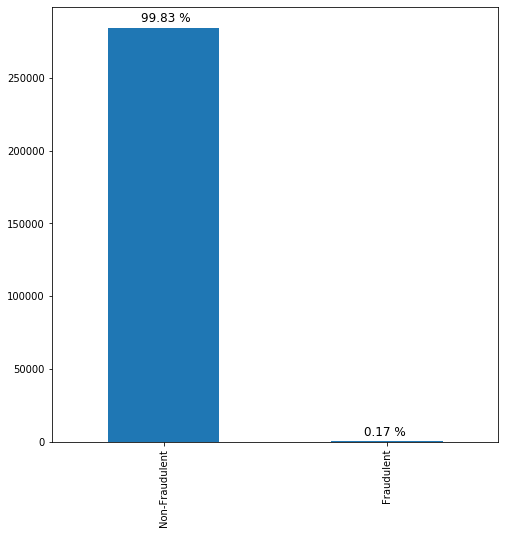

In [116]:
##### Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
ax = classes.plot(kind='bar', figsize=(8,8), tick_label=['Non-Fraudulent','Fraudulent'])
plt.xticks(ticks = [0,1], labels=['Non-Fraudulent','Fraudulent'])
plt.text(x=-0.10, y=classes[0] + 4000, s=str(round(normal_share, 2)) + ' %', size=12)
plt.text(x=0.9, y=classes[1] + 4000, s=str(round(fraud_share, 2)) + ' %', size = 12)
plt.show()

In [117]:
# Create a scatter plot to observe the distribution of classes with time
# seconds in a day = 60 x 60 x 24 = 86400 i.e in 2 days = 172800
# highest value in the time column = 172792
# since the data is from just 2 days, we can conclude that the 
# data is from 00:00:00 on day 1 to 11:59:59 on day 2
# so doing a modulo of the time value by 86400 gives us 
# the seconds elapsed from 00:00 in each day using which we can create bins
df['seconds_from_12_am'] = df['Time'] % 86400
bins = [-1, 14400, 28800, 43200, 57600, 72000, 86401]
labels = ['midnight to 4am', '4am to 8am', '8am to noon', 'noon to 4pm', '4pm to 8pm', '8pm to midnight']
df['Time_Slot'] = pd.cut(df['seconds_from_12_am'], bins, labels=labels)
df.tail(200)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,seconds_from_12_am,Time_Slot
284607,172595.0,-0.128780,1.290989,-0.584634,-0.424729,1.068268,-0.951651,1.119394,-0.289588,-0.040139,...,-0.346699,-0.708009,-0.335079,-0.116525,0.344570,0.294544,4.39,0,86195.0,8pm to midnight
284608,172599.0,-0.195044,1.238305,-0.768720,-0.178302,0.582600,-1.282570,0.946855,-0.129767,-0.040571,...,-0.111128,-0.162594,-0.896012,-0.259841,-0.131265,-0.005010,18.16,0,86199.0,8pm to midnight
284609,172599.0,2.035871,-0.069877,-1.168968,0.208965,0.162972,-0.601478,0.101776,-0.176646,0.207296,...,0.287104,-0.378273,-0.278012,0.201952,-0.067508,-0.072807,0.89,0,86199.0,8pm to midnight
284610,172602.0,-3.849825,3.978385,-5.138427,-0.756156,-1.496193,-1.344611,-1.733808,3.273432,-0.870490,...,0.213363,0.046459,0.381029,-0.417428,-1.409201,-0.350954,11.76,0,86202.0,8pm to midnight
284611,172604.0,-0.853878,0.781617,1.379211,-0.846809,0.073660,0.074457,0.224597,0.069018,0.286244,...,-0.298727,-0.248777,-0.321043,0.510994,-0.029603,0.222621,10.00,0,86204.0,8pm to midnight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,86386.0,8pm to midnight
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,86387.0,8pm to midnight
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,86388.0,8pm to midnight
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,86388.0,8pm to midnight


In [118]:
series_counts = df.groupby('Class')['Time_Slot'].value_counts().rename('count')
df_counts = pd.DataFrame(series_counts)
df_counts = df_counts.reset_index()
df_counts

,Class,Time_Slot,count
0,0,4pm to 8pm,65205
1,0,noon to 4pm,63729
2,0,8pm to midnight,60771
3,0,8am to noon,59487
4,0,midnight to 4am,18647
5,0,4am to 8am,16476
6,1,4pm to 8pm,103
7,1,midnight to 4am,90
8,1,8am to noon,86
9,1,noon to 4pm,83


In [119]:
print('---Average Amount in both class---')
print(df.groupby('Class')['Amount'].mean())
print('\n')
print('---Max Amount in both class---')
print(df.groupby('Class')['Amount'].max())
print('\n')
print('---Min Amount in both class---')
print(df.groupby('Class')['Amount'].min())

---Average Amount in both class---
Class
0     88.291022
1    122.211321
Name: Amount, dtype: float64


---Max Amount in both class---
Class
0    25691.16
1     2125.87
Name: Amount, dtype: float64


---Min Amount in both class---
Class
0    0.0
1    0.0
Name: Amount, dtype: float64


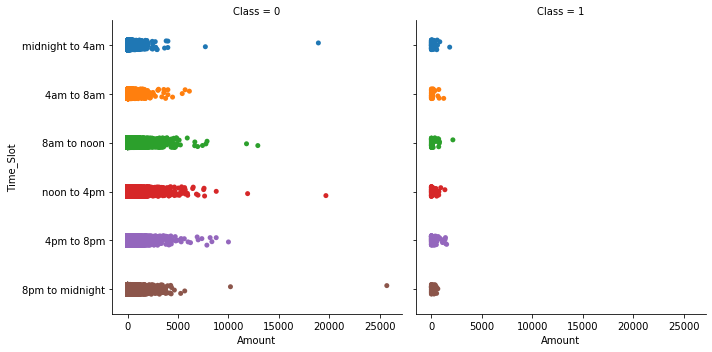

<Figure size 576x1152 with 0 Axes>

In [120]:
# Create a scatter plot to observe the distribution of classes with Amount
sns.catplot(x='Amount', y='Time_Slot', data=df, col='Class')
plt.figure(figsize = (8,16))
plt.show()

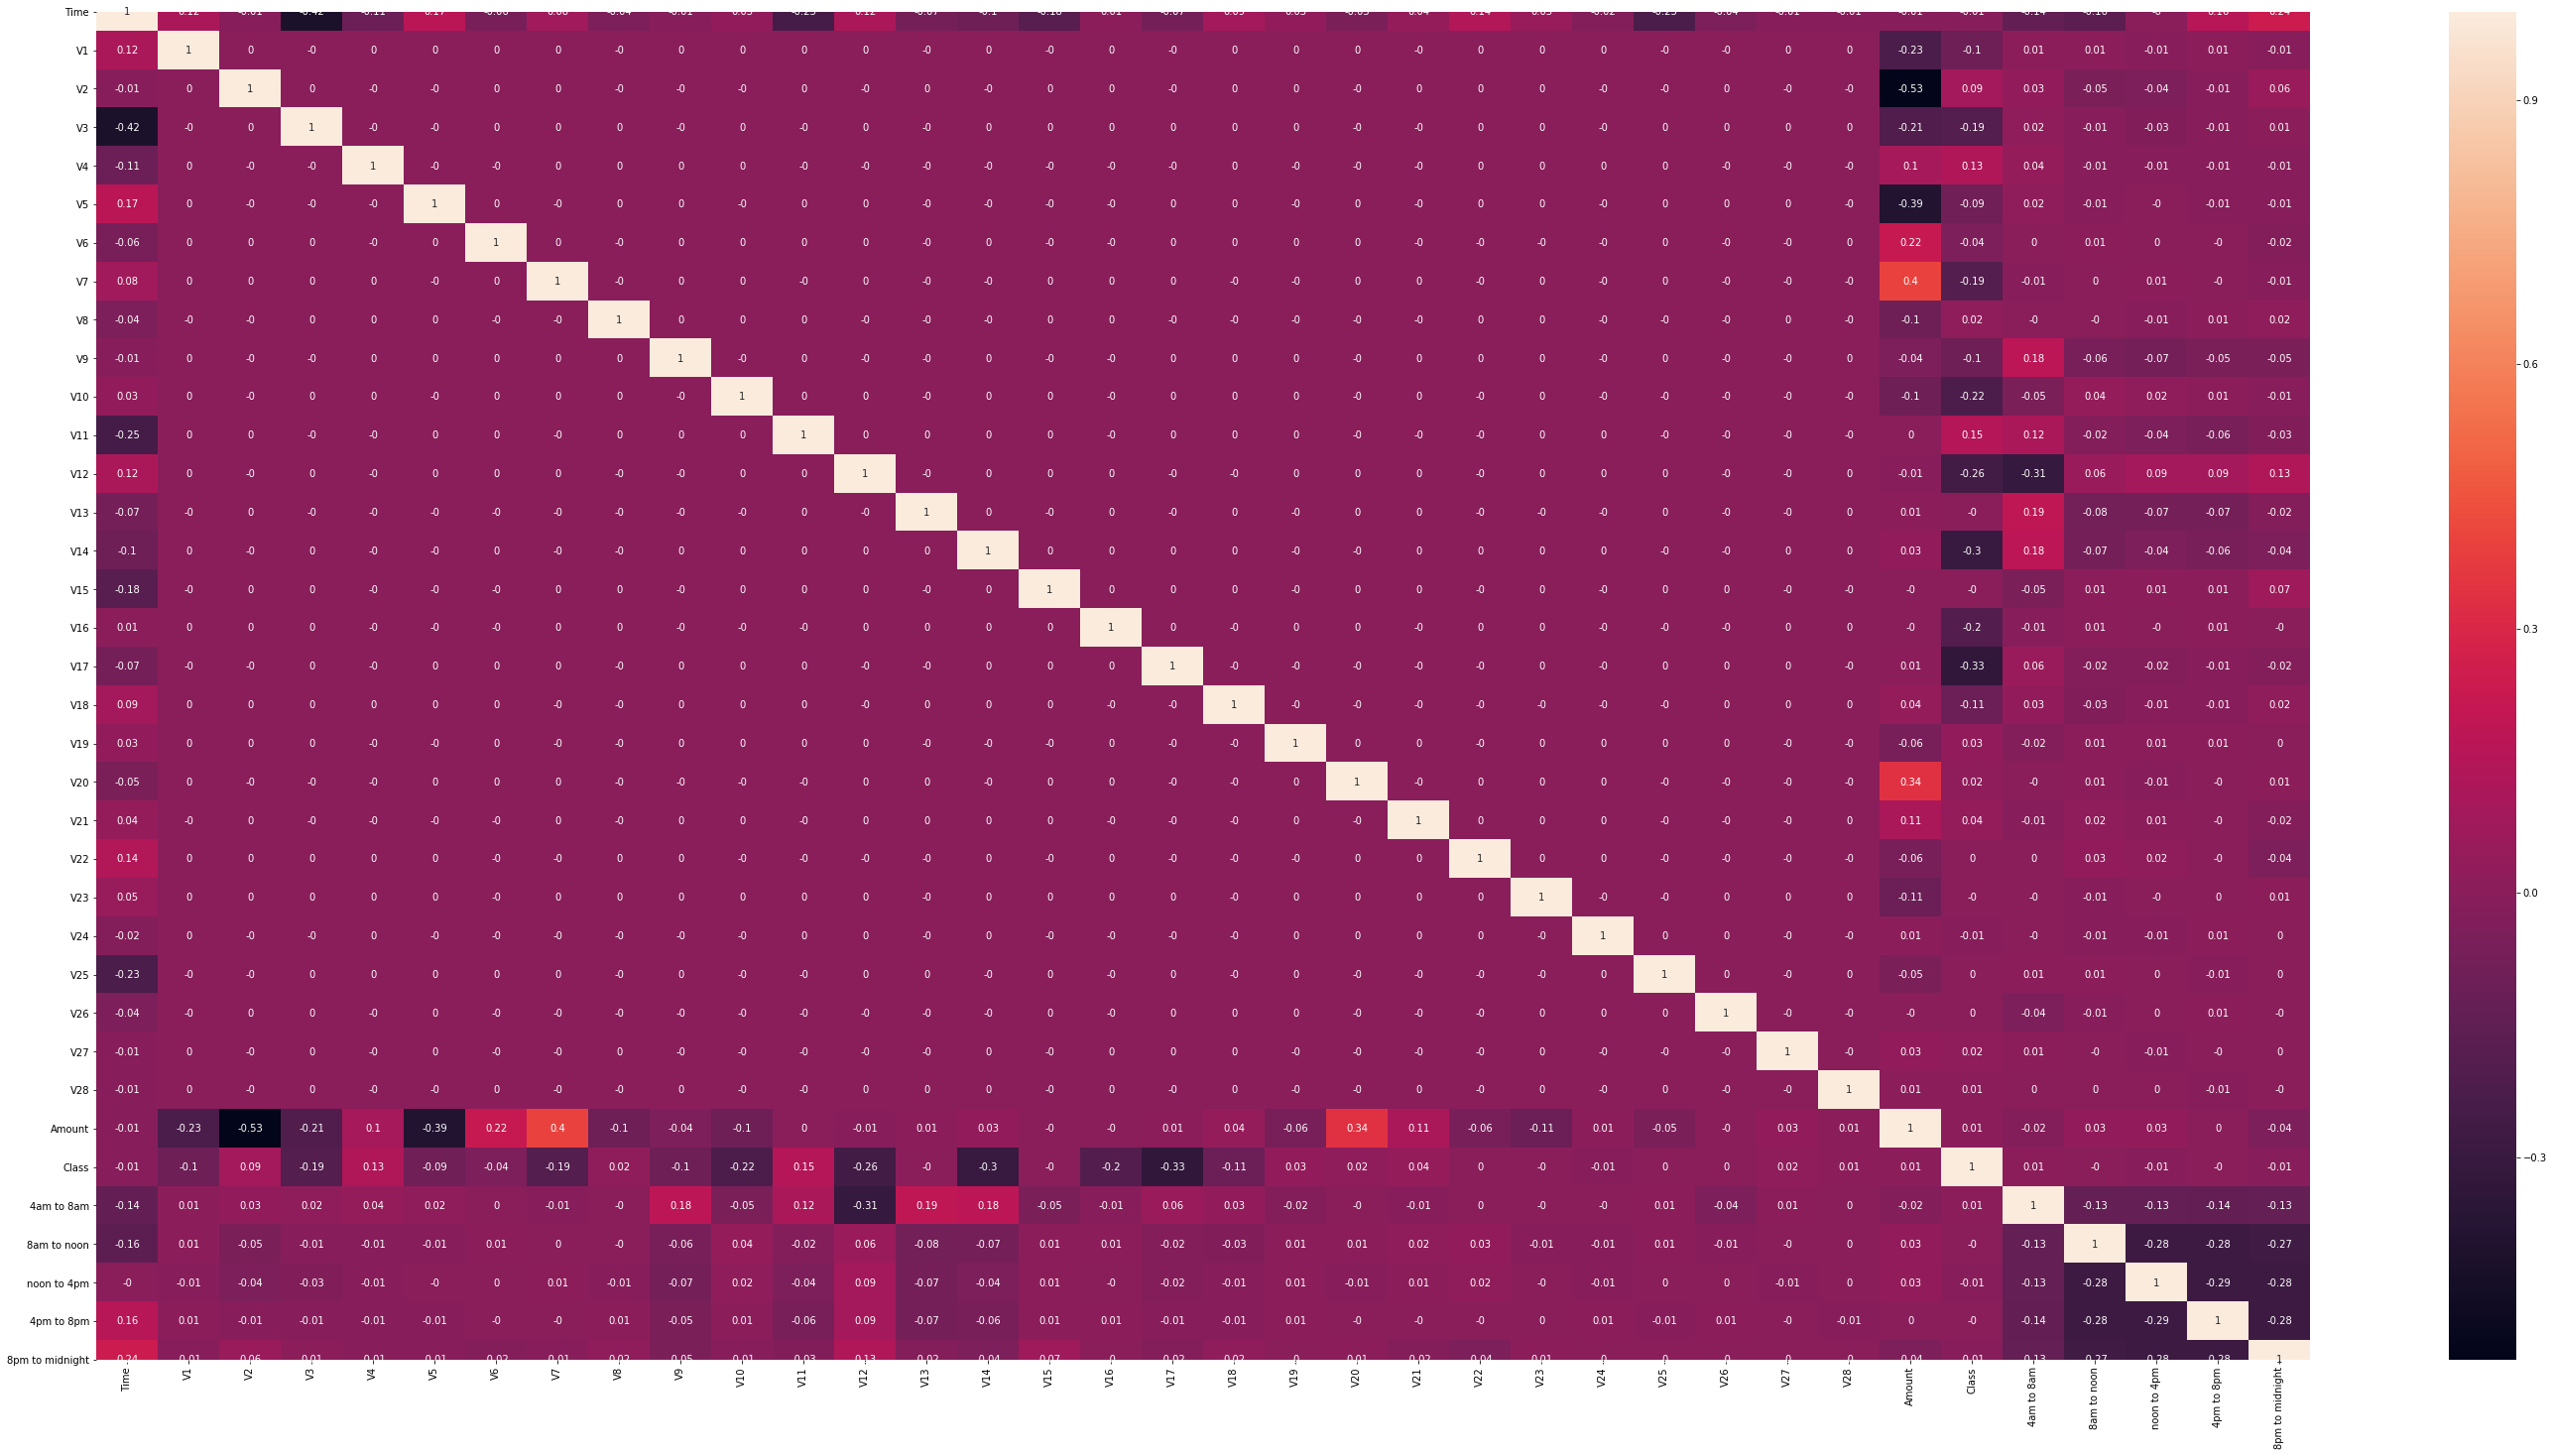

In [121]:
# Drop unnecessary columns
# Creating dummy variables for Time_Slot and dropping the first one.
dummies = pd.get_dummies(df['Time_Slot'], drop_first=True)

# Adding the results to the master dataframe
df = pd.concat([df, dummies], axis=1)

# Dropping the original columns
df = df.drop(['seconds_from_12_am','Time_Slot'], axis=1)

# Let's see the correlation matrix 
plt.figure(figsize = (50,25))        # Size of the figure
sns.heatmap(df.corr().round(2),annot = True)
plt.savefig('./heat_map_initial.png', bbox_inches='tight')
plt.show()

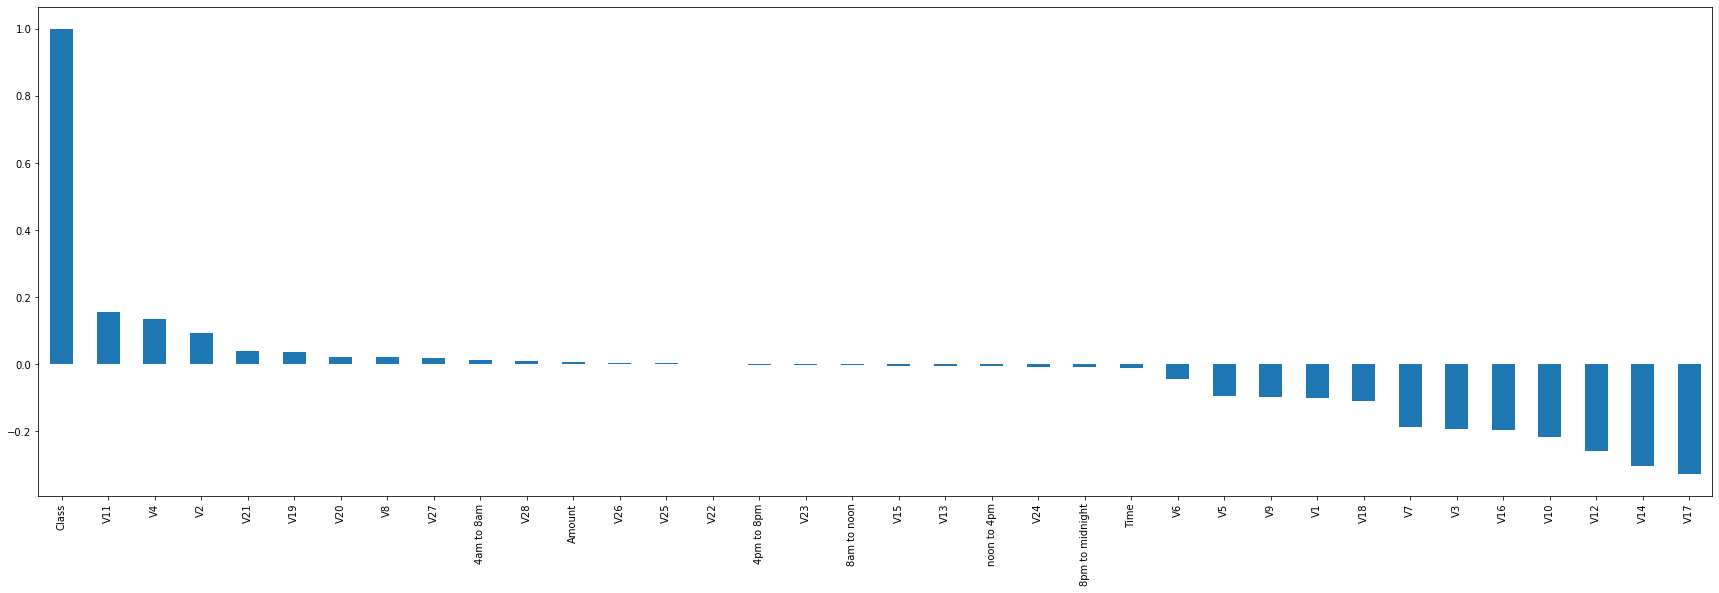

In [122]:
#Get Correlation of "Class" with other variables:
plt.figure(figsize=(30,9))
df.corr()['Class'].sort_values(ascending = False).plot(kind = 'bar')
plt.show()

#### inferences:
- Class is highly positively correlated to V11, V4 and V2
- Class is highly negatively correlated to V17, V14 and V12
- Class has no correlation or zero correlation with V25, V22 and 4pm to 8pm

### Feature Scaling

In [123]:
from sklearn import preprocessing
# removing the scaling of data for the two fields as doing an 
# inverse transform to get the actual amounts back is giving errors at the end

# from sklearn.preprocessing import StandardScaler

# create list of numeric vars
# num_vars = ['Time', 'Amount']

# 2. fit on data
# scaler = StandardScaler().fit(df[num_vars])
# df[num_vars] = scaler.transform(df[num_vars])

In [124]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V26,V27,V28,Amount,Class,4am to 8am,8am to noon,noon to 4pm,4pm to 8pm,8pm to midnight
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.189115,0.133558,-0.021053,149.62,0,0,0,0,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.125895,-0.008983,0.014724,2.69,0,0,0,0,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.139097,-0.055353,-0.059752,378.66,0,0,0,0,0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.221929,0.062723,0.061458,123.50,0,0,0,0,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.502292,0.219422,0.215153,69.99,0,0,0,0,0,0


### Splitting the data into train & test data

In [125]:
X = df.drop('Class', axis = 1)
y = df.pop('Class')

# keeping the original X and y 
X_orig = X.copy()
y_orig = y.copy()

print(X.shape)
print(y.shape)

(284807, 35)
(284807,)


In [126]:
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

##### Preserve X_test & y_test to evaluate on the test data once you build the model

In [127]:
print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
350
142


### Plotting the distribution of a variable

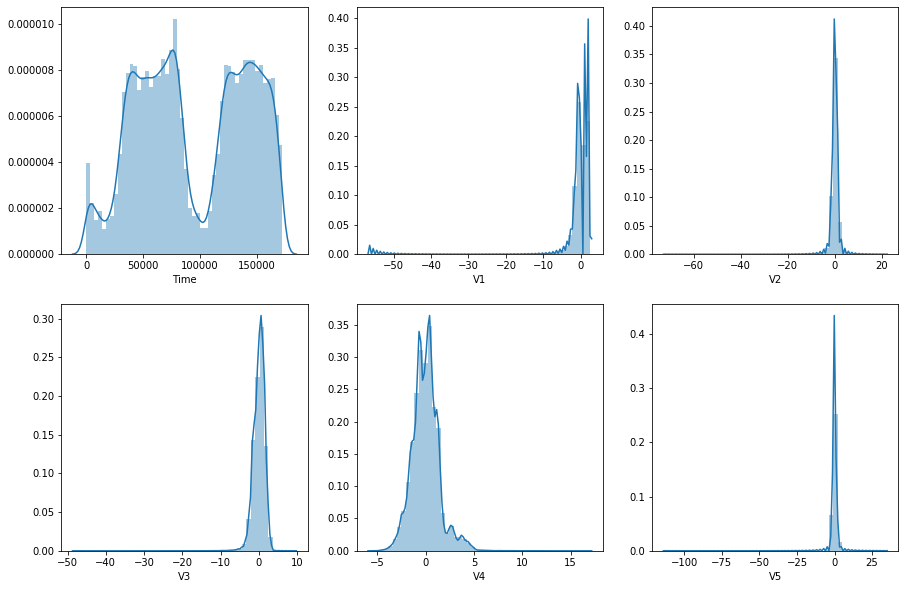

In [128]:
# plot the histogram of variable from the dataset to see the skewness
plt.figure(figsize = (15,10))
plt.subplot(231)
sns.distplot(X['Time'])
plt.subplot(232)
sns.distplot(X['V1'])
plt.subplot(233)
sns.distplot(X['V2'])
plt.subplot(234)
sns.distplot(X['V3'])
plt.subplot(235)
sns.distplot(X['V4'])
plt.subplot(236)
sns.distplot(X['V5'])
plt.show()

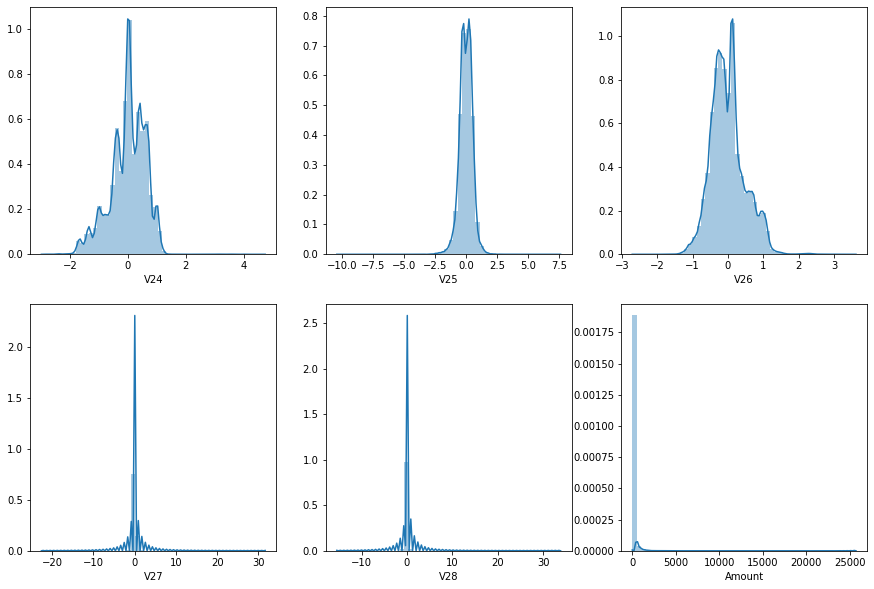

In [129]:
plt.figure(figsize = (15,10))
plt.subplot(231)
sns.distplot(X['V24'])
plt.subplot(232)
sns.distplot(X['V25'])
plt.subplot(233)
sns.distplot(X['V26'])
plt.subplot(234)
sns.distplot(X['V27'])
plt.subplot(235)
sns.distplot(X['V28'])
plt.subplot(236)
sns.distplot(X['Amount'])
plt.show()

## There is no skewness present in the distribution except for the 'Time' variable

### If there is skewness present in the distribution use:
- <b>Power Transformer</b> package present in the <b>preprocessing library provided by sklearn</b> to make distribution more gaussian

In [130]:
train_Time = X_train['Time'].to_frame()
test_Time = X_test['Time'].to_frame()

# PowerTransfrom 'Time' varaible
pt = PowerTransformer(copy = False)
pt.fit(train_Time) 

train_time = pt.transform(train_Time)
test_time = pt.transform(test_Time)

X_train['Time'] = train_time
X_test['Time'] = test_time

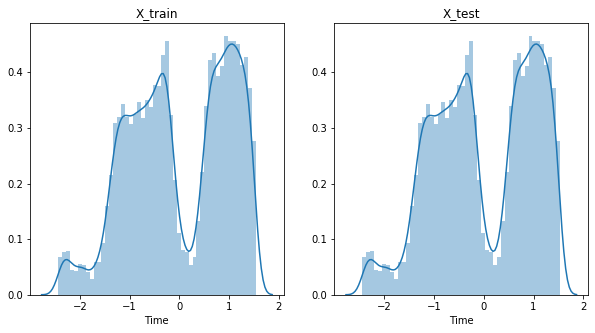

In [131]:
# plot the histogram of a variable from the dataset again to see the result 
plt.figure(figsize=(10,5))
plt.subplot(121)
sns.distplot(X_test['Time'])
plt.title('X_train')
plt.subplot(122)
sns.distplot(X_test['Time'])
plt.title('X_test')
plt.show()

## Model Building
- Build different models on the imbalanced dataset and see the result

### Logistic Regression

In [132]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Predicted probabilities
y_pred = lr.predict(X_test)

# Converting y_pred to a dataframe which is an array
df_y_pred = pd.DataFrame(y_pred)

In [133]:
confusion = confusion_matrix(y_test,y_pred)
confusion

array([[85273,    28],
       [   48,    94]], dtype=int64)

In [134]:
print("Logistic Regression accuracy:  ",metrics.accuracy_score(y_test,y_pred))
print("Logistic Regression recall  :  ",metrics.recall_score(y_test,y_pred))

Logistic Regression accuracy:   0.9991105181231933
Logistic Regression recall  :   0.6619718309859155


### Eventhough we have a very high accuracy, we can observe from the confusion matrix that the model has been able to predict very less true positives which implies our model is not good enough. Let's try to choose sample using StratifiedK-fold cross validation technique

#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv 
- y_train_cv
- y_test_cv 

In [135]:
# Stratified cross validation
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in skf.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]


In [136]:
# Logistic Regression on cross validated dataset
lr = LogisticRegression()
lr.fit(X_train_cv, y_train_cv)

# Predicted probabilities
y_pred = lr.predict(X_test_cv)

# Converting y_pred to a dataframe which is an array
df_y_pred = pd.DataFrame(y_pred)

In [137]:
# evaluation metrics
confusion = confusion_matrix(y_test_cv,y_pred)
print(confusion)

print("Logistic Regression accuracy after cross validation:  ",metrics.accuracy_score(y_test_cv,y_pred))
print("Logistic Regression recall after cross validation  :  ",metrics.recall_score(y_test_cv,y_pred))

[[56863     0]
 [   88    10]]
Logistic Regression accuracy after cross validation:   0.9984550833026106
Logistic Regression recall after cross validation  :   0.10204081632653061


### Recall gone even lower after Stratified cross validation. Let's try using different models

### K Nearest Neighbour

### Finding the best k in KNN

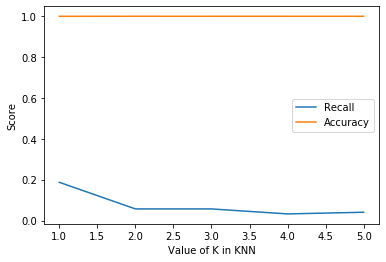

In [228]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

X_train,X_test,y_train,y_test =train_test_split(X_orig, y_orig, stratify=y_orig, random_state=100)

k_range = [1, 2, 3, 4, 5]
accuracy = []
recall=[]
for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    recall.append(recall_score(y_test,y_pred))
    accuracy.append(accuracy_score(y_test,y_pred))
    
%matplotlib inline
plt.plot(k_range,recall,label= 'Recall')
plt.plot(k_range,accuracy,label= 'Accuracy')
plt.xlabel('Value of K in KNN')
plt.ylabel('Score')
plt.legend()

In [231]:
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print('Recall of KNN n=3 on the testing dataset is :{:.3f}'.format(recall_score(y_test,y_pred)))

Recall of KNN n=3 on the testing dataset is :0.057


### Since using KNN also the recall score is just 5.7%. Let's use other model as well

### Decision Tree using default parameters

In [140]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

X = X_orig.copy()
y = y_orig.copy()

# Splitting the data into train and test
X_train,X_test,y_train,y_test =train_test_split(X_orig, y_orig, stratify=y_orig, random_state=100)

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt1 = DecisionTreeClassifier(max_depth=5)
dt1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [141]:
# The evaluation metrics of our default model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Making predictions
y_pred_dt = dt1.predict(X_test)

# Printing classification report
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.92      0.78      0.85       123

    accuracy                           1.00     71202
   macro avg       0.96      0.89      0.92     71202
weighted avg       1.00      1.00      1.00     71202



In [142]:
# Printing confusion matrix and accuracy
print(confusion_matrix(y_test,y_pred_dt))
print('Accuracy of Decision Tree :',accuracy_score(y_test,y_pred_dt))
print('Sensitivity of Decision Tree :',recall_score(y_test,y_pred_dt))

[[71071     8]
 [   27    96]]
Accuracy of Decision Tree : 0.9995084407741356
Sensitivity of Decision Tree : 0.7804878048780488


### Eventhough we have an accuracy of 99.95% we still have a low sensitivity score of 78.1%. Lets tune the model and try to improve it

### Hyperparameter tuning

### Tuning max_depth

In [143]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 10)}

# instantiate the model
dt = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dt, parameters, 
                    cv=n_folds, 
                    return_train_score=True,
                    scoring="recall")
tree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None, param_grid={'max_depth': range(1, 10)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='

In [144]:
# scores of GridSearch CV
score = tree.cv_results_
pd.DataFrame(score).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.672813,0.013883,0.020395,0.001498,1,{'max_depth': 1},0.648649,0.689189,0.756757,0.621622,...,0.672010,0.047656,9,0.691525,0.644068,0.664407,0.698305,0.699324,0.679526,0.021792
1,1.246284,0.019327,0.021590,0.001357,2,{'max_depth': 2},0.702703,0.824324,0.797297,0.675676,...,0.745205,0.056537,7,0.779661,0.728814,0.749153,0.762712,0.770270,0.758122,0.017731
2,1.806162,0.026588,0.020591,0.002061,3,{'max_depth': 3},0.702703,0.810811,0.797297,0.689189,...,0.739726,0.052879,8,0.779661,0.715254,0.755932,0.772881,0.753378,0.755421,0.022406
3,2.469779,0.053514,0.019592,0.001956,4,{'max_depth': 4},0.702703,0.837838,0.797297,0.716216,...,0.772454,0.053291,3,0.813559,0.803390,0.766102,0.820339,0.834459,0.807570,0.023061
4,2.956700,0.073905,0.021387,0.001495,5,{'max_depth': 5},0.716216,0.837838,0.810811,0.702703,...,0.775157,0.054803,1,0.837288,0.820339,0.820339,0.844068,0.831081,0.830623,0.009348


In [145]:
### Generic method to plot accuracy of params while tuning
def plot_param_accuracies(inp_score, inp_param_name, model_name):
    plt.figure()
    plt.grid(color='grey', linestyle='--', linewidth=0.5)
    plt.plot(inp_score['param_' + inp_param_name], inp_score['mean_train_score'], label='training recall')
    plt.plot(inp_score['param_' + inp_param_name], inp_score['mean_test_score'], label = 'test recall')
    plt.xlabel(inp_param_name)
    plt.ylabel('Recall')
    plt.legend()
    plt.show()

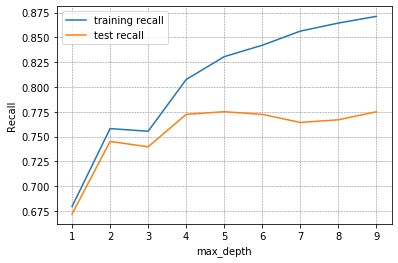

In [146]:
# plotting accuracies with max_depth
plot_param_accuracies(score, 'max_depth', 'decision_tree')

#### According to above plot, max_depth = 6 is optimal

### Tuning min_samples_leaf

In [147]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds,
                    return_train_score=True,
                    scoring="recall")
tree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_leaf': range(5, 200, 20)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Tru

In [148]:
# scores of GridSearch CV
score = tree.cv_results_
pd.DataFrame(score).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,9.049979,1.036948,0.023302,0.002653,5,{'min_samples_leaf': 5},0.729730,0.851351,0.810811,0.716216,...,0.775046,0.050357,1,0.861017,0.796610,0.806780,0.850847,0.817568,0.826564,0.025085
1,9.025733,1.054834,0.022970,0.001888,25,{'min_samples_leaf': 25},0.729730,0.837838,0.810811,0.675676,...,0.766975,0.058065,2,0.813559,0.789831,0.776271,0.789831,0.790541,0.792006,0.012031
2,9.313816,1.331582,0.022381,0.002339,45,{'min_samples_leaf': 45},0.702703,0.689189,0.756757,0.716216,...,0.685302,0.065834,3,0.789831,0.644068,0.664407,0.786441,0.631757,0.703301,0.070056
3,9.254365,1.547101,0.025174,0.001444,65,{'min_samples_leaf': 65},0.648649,0.689189,0.756757,0.621622,...,0.672010,0.047656,4,0.691525,0.644068,0.664407,0.698305,0.699324,0.679526,0.021792
4,7.435926,0.879564,0.024987,0.007659,85,{'min_samples_leaf': 85},0.648649,0.689189,0.756757,0.621622,...,0.672010,0.047656,4,0.691525,0.644068,0.664407,0.698305,0.699324,0.679526,0.021792


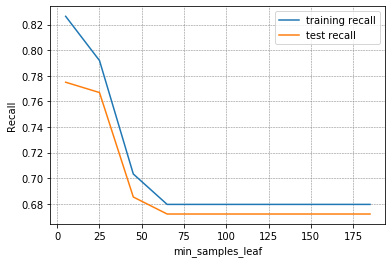

In [149]:
# plotting accuracies with min_samples_leaf
plot_param_accuracies(score, 'min_samples_leaf', 'decision_tree')

#### min_samples_leaf = 25 looks to be optimal

### Tuning min_samples_split

In [150]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(5, 400, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds,
                    return_train_score=True,
                    scoring="recall")
tree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_split': range(5, 400, 20)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Tr

In [151]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,8.380860,0.929204,0.022996,0.005270,5,{'min_samples_split': 5},0.716216,0.851351,0.756757,0.675676,...,0.753424,0.058682,5,0.989831,0.983051,0.983051,0.983051,0.979730,0.983743,0.003305
1,8.470582,0.897820,0.024618,0.004650,25,{'min_samples_split': 25},0.702703,0.824324,0.783784,0.662162,...,0.748019,0.058123,13,0.928814,0.884746,0.908475,0.922034,0.885135,0.905841,0.018279
2,8.337995,0.897115,0.021784,0.007705,45,{'min_samples_split': 45},0.689189,0.824324,0.770270,0.689189,...,0.750759,0.053438,12,0.905085,0.877966,0.857627,0.905085,0.868243,0.882801,0.019298
3,8.359222,0.879062,0.019188,0.005197,65,{'min_samples_split': 65},0.702703,0.824324,0.770270,0.689189,...,0.756201,0.052268,4,0.891525,0.884746,0.844068,0.898305,0.888514,0.881432,0.019203
4,8.343657,0.921517,0.021955,0.005245,85,{'min_samples_split': 85},0.729730,0.837838,0.824324,0.729730,...,0.783228,0.045876,1,0.905085,0.874576,0.891525,0.905085,0.868243,0.888903,0.015249


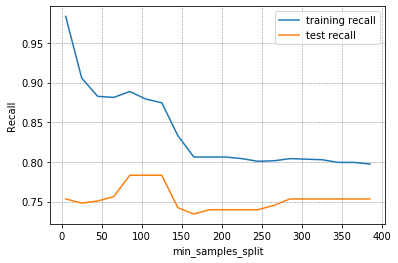

In [152]:
# plotting accuracies with min_samples_split
plot_param_accuracies(scores, 'min_samples_split', 'decision_tree')

#### min_samples_split = 125 looks optimal

In [153]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(2, 8),
    'min_samples_leaf': range(20, 35, 5),
    'min_samples_split': range(50, 150, 25),
    'criterion': ['gini']
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, 
                           param_grid = param_grid,
                           return_train_score=True,
                           scoring = 'recall',
                           cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 16.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini'], 'max_depth': range(2, 8),
                         'min_samples_leaf': range(20, 35, 5),

In [154]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results
# printing the optimal accuracy score and hyperparameters
print("Best Score", grid_search.best_score_)

Best Score 0.8129949460444904


In [155]:
print(grid_search.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


In [156]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = 'gini', 
                                  random_state = 100,
                                  max_depth=6, 
                                  min_samples_leaf=25,
                                  min_samples_split=100)
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=100, splitter='best')

In [157]:
y_pred_dt = clf_gini.predict(X_test)

In [158]:
print(confusion_matrix(y_pred_dt,y_test))

[[71050    30]
 [   29    93]]


In [159]:
# metric score
print ('Accuracy Score for Decision Tree Final Model :', accuracy_score(y_pred_dt,y_test))
print ('Recall Score for Decision Tree Final Model :', recall_score(y_pred_dt,y_test))

Accuracy Score for Decision Tree Final Model : 0.9991713715906857
Recall Score for Decision Tree Final Model : 0.7622950819672131


## A Tuned Decision Tree has given us an accuracy of 99.92% and a recall of 76.22%

### Random Forest with default parameters

In [160]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X = X_orig.copy()
y = y_orig.copy()

X_train,X_test,y_train,y_test =train_test_split(X_orig, y_orig, stratify=y_orig, random_state=100)

model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)
print(classification_report(y_test,prediction_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.98      0.74      0.84       123

    accuracy                           1.00     71202
   macro avg       0.99      0.87      0.92     71202
weighted avg       1.00      1.00      1.00     71202



In [161]:
# Printing confusion matrix
print(confusion_matrix(y_test, prediction_test))

[[71077     2]
 [   32    91]]


In [162]:
print ('Random Forest Accuracy with Default Hyperparameter', metrics.accuracy_score(y_test, prediction_test))
print ('Random Forest Recall with Default Hyperparameter  ', recall_score(y_test, prediction_test))

Random Forest Accuracy with Default Hyperparameter 0.999522485323446
Random Forest Recall with Default Hyperparameter   0.7398373983739838


### With Random Forest, the recall score is just 73.98%

### XGBoost

### Finding the best n_estimator

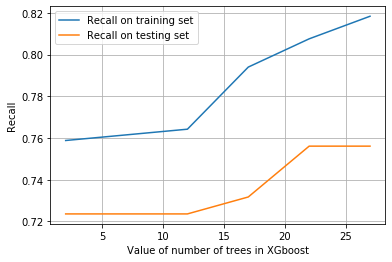

In [163]:
from xgboost import XGBClassifier

X_train,X_test,y_train,y_test =train_test_split(X_orig, y_orig, stratify=y_orig, random_state=100)

tree_range = range(2, 30, 5)
train_recall=[]
test_recall=[]
for tree in tree_range:
    xgb=XGBClassifier(n_estimators=tree)
    xgb.fit(X_train,y_train)
    y_train_pred = xgb.predict(X_train)
    y_test_pred = xgb.predict(X_test)
    train_recall.append(recall_score(y_train,y_train_pred))
    test_recall.append(recall_score(y_test,y_test_pred))
    
%matplotlib inline
plt.plot(tree_range,train_recall,label= 'Recall on training set')
plt.plot(tree_range,test_recall,label= 'Recall on testing set')
plt.xlabel('Value of number of trees in XGboost')
plt.ylabel('Recall')
plt.grid()
plt.legend()

### Here best number of trees in XGB is 22

In [165]:
clf = XGBClassifier(n_estimators=22)  #initialise the model with optimum hyperparameters
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
#print the evaluation score on the X_test by choosing the best evaluation metric
print('Recall of XGB n=22 on the testing dataset is :{:.3f}'.format(recall_score(y_test,y_test_pred)))

Recall of XGB n=22 on the testing dataset is :0.756


### With XGBoost the recall score is about 75.6% 

### Print the important features of the best model to understand the dataset
- This will not give much explanation on the already transformed dataset
- But it will help us in understanding if the dataset is not PCA transformed

Top var = 18
2nd Top var = 15
3rd Top var = 8


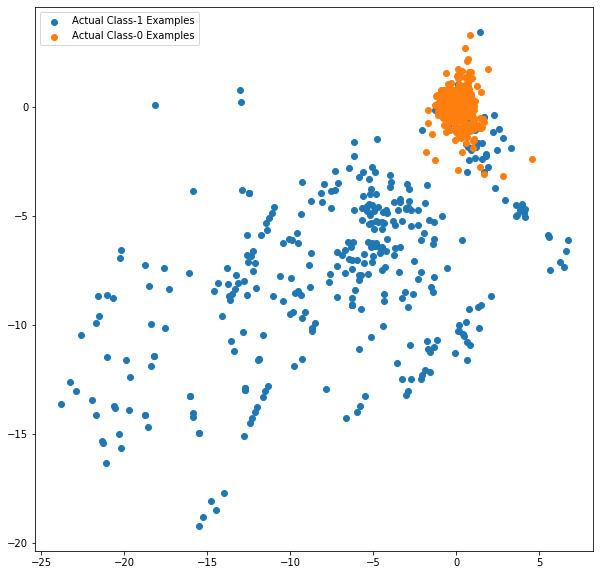

In [166]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-16 and Index-13 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

## Model building with balancing Classes

##### Perform class balancing with :
- Random Oversampling
- SMOTE
- ADASYN

## Model Building
- Build different models on the balanced dataset and see the result

### Random OverSampling

In [167]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

X = X_orig.copy()
y = y_orig.copy()

# define oversampling technique
over_sample = RandomOverSampler(sampling_strategy='minority')

# fit and apply the transform
X_over, y_over = over_sample.fit_resample(X, y)
# summarize class distribution
print(Counter(y_over))

Counter({0: 284315, 1: 284315})


### The class distribution for the transformed dataset shows that the minority class has the same number of examples as the majority class.

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, train_size=0.7, test_size=0.3, random_state=100)

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Predicted probabilities
y_pred = lr.predict(X_test)

# Converting y_pred to a dataframe which is an array
df_y_pred = pd.DataFrame(y_pred)

In [169]:
confusion = confusion_matrix(y_test,y_pred)
confusion

array([[82897,  2094],
       [ 8537, 77061]], dtype=int64)

In [170]:
print("Logistic Regression accuracy:  ",metrics.accuracy_score(y_test,y_pred))
print("Logistic Regression recall  :  ",metrics.recall_score(y_test,y_pred))

Logistic Regression accuracy:   0.9376806241903054
Logistic Regression recall  :   0.9002663613635833


### Recall has drastically increased to 90.0%. Let's try different model as well.

### Decision tree with Default Hyperparameter

In [171]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

X = X_over.copy()
y = y_over.copy()

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt1 = DecisionTreeClassifier(max_depth=5)
dt1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [172]:
# The evaluation metrics of our default model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Making predictions
y_pred1 = dt1.predict(X_test)

# Printing classification report
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96     84991
           1       0.98      0.95      0.96     85598

    accuracy                           0.96    170589
   macro avg       0.96      0.96      0.96    170589
weighted avg       0.96      0.96      0.96    170589



In [173]:
# Printing confusion matrix and accuracy
print(confusion_matrix(y_test,y_pred1))
print('Accuracy of Decision Tree :',accuracy_score(y_test,y_pred1))
print('Recall of Decision Tree   :',recall_score(y_test,y_pred1))

[[83284  1707]
 [ 4368 81230]]
Accuracy of Decision Tree : 0.9643880906740763
Recall of Decision Tree   : 0.9489707703451015


### We have an accuracy of 96.4% and recall score of 94.9%. Lets tune the model and try to improve it

# Hyperparameter tuning

### Random Forest with default parameters

In [174]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X = X_over.copy()
y = y_over.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)
print(classification_report(y_test,prediction_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84991
           1       1.00      1.00      1.00     85598

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589



In [175]:
# Printing confusion matrix
print(confusion_matrix(y_test, prediction_test))

[[84979    12]
 [    0 85598]]


In [176]:
print ('Random Forest Accuracy with Default Hyperparameter', accuracy_score(y_test, prediction_test))
print ('Random Forest Recall with Default Hyperparameter  ', recall_score(y_test, prediction_test))

Random Forest Accuracy with Default Hyperparameter 0.9999296554877513
Random Forest Recall with Default Hyperparameter   1.0


### With default parameters, we get a 99.99% accuracy in Random forest model and 100% recall!!

### XGBoost

### Finding the best n_estimator

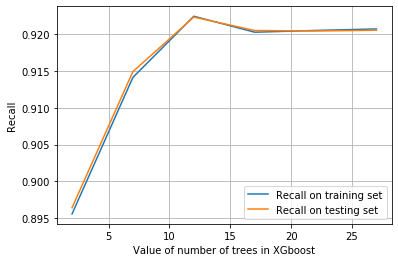

In [177]:
from xgboost import XGBClassifier

X = X_over.copy()
y = y_over.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

tree_range = range(2, 30, 5)
train_recall=[]
test_recall=[]
for tree in tree_range:
    xgb=XGBClassifier(n_estimators=tree)
    xgb.fit(X_train,y_train)
    y_train_pred = xgb.predict(X_train)
    y_test_pred = xgb.predict(X_test)
    train_recall.append(recall_score(y_train,y_train_pred))
    test_recall.append(recall_score(y_test,y_test_pred))
    
%matplotlib inline
plt.plot(tree_range,train_recall,label= 'Recall on training set')
plt.plot(tree_range,test_recall,label= 'Recall on testing set')
plt.xlabel('Value of number of trees in XGboost')
plt.ylabel('Recall')
plt.grid()
plt.legend()

In [178]:
xgb=XGBClassifier(n_estimators=12)
xgb.fit(X_train,y_train)
y_test_pred = xgb.predict(X_test)
print('Recall of XGB n=12 on the testing dataset is :{:.3f}'.format(recall_score(y_test,y_test_pred)))

Recall of XGB n=12 on the testing dataset is :0.922


### Here best number of trees in XGB is 6 at which the recall is around 92.2%

### Print the class distribution after applying SMOTE 

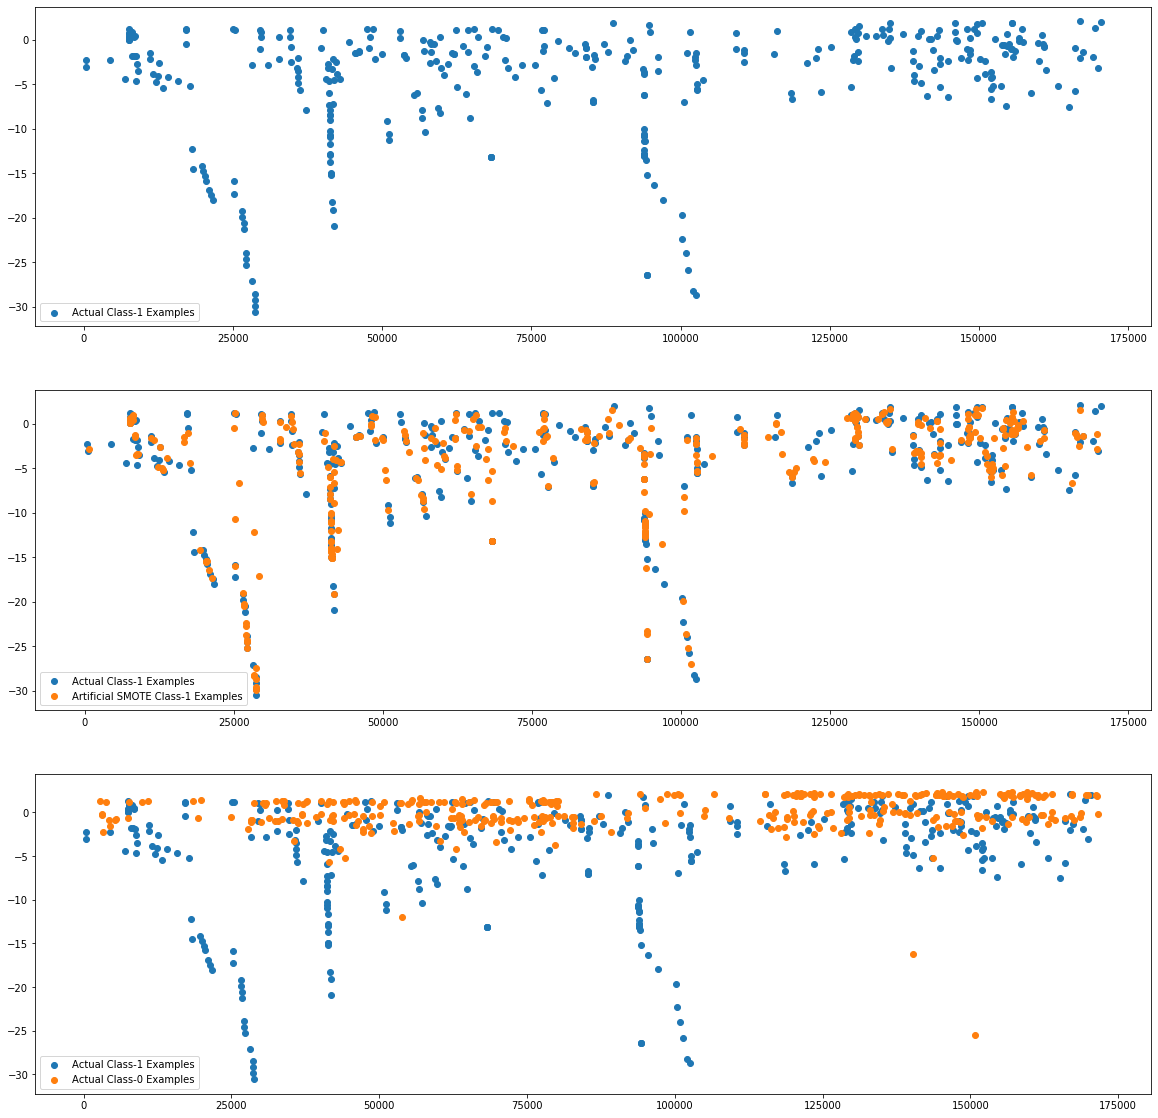

In [179]:
import warnings
warnings.filterwarnings("ignore")

from imblearn import over_sampling

X_train,X_test,y_train,y_test = train_test_split(X_orig, y_orig, stratify=y_orig, random_state=100)

sm = over_sampling.SMOTE(random_state=0)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from SMOTE are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from SMOTE, we do
X_train_smote_1 = X_train_smote[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]


plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_smote_1[:X_train_1.shape[0], 0], X_train_smote_1[:X_train_1.shape[0], 1],
            label='Artificial SMOTE Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

In [180]:
#perform cross validation & then balance classes on X_train_cv & y_train_cv using SMOTE
# Stratified cross validation
X_smote, y_smote = sm.fit_resample(X_orig, y_orig)
X_smote = pd.DataFrame(X_smote)
y_smote = pd.DataFrame(y_smote)

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in skf.split(X_smote, y_smote):
    print("Train:", train_index, "Test:", test_index)
    X_train_cv, X_test_cv = X_smote.iloc[train_index], X_smote.iloc[test_index]
    y_train_cv, y_test_cv = y_smote.iloc[train_index], y_smote.iloc[test_index]

Train: [ 57020  57021  57022 ... 568627 568628 568629] Test: [     0      1      2 ... 341175 341176 341177]
Train: [     0      1      2 ... 568627 568628 568629] Test: [ 57020  57021  57022 ... 398038 398039 398040]
Train: [     0      1      2 ... 568627 568628 568629] Test: [113967 113968 113969 ... 454901 454902 454903]
Train: [     0      1      2 ... 568627 568628 568629] Test: [170949 170950 170951 ... 511764 511765 511766]
Train: [     0      1      2 ... 511764 511765 511766] Test: [227869 227870 227871 ... 568627 568628 568629]


In [181]:
X_smote.columns = X_orig.columns
y_smote.columns = ['Class']
print('1: ', len(y_smote[y_smote['Class'] == 1]))
print('0: ', len(y_smote[y_smote['Class'] == 0]))

1:  284315
0:  284315


### Number of fraudulent and non fraudulent transactions are now the same with SMOTE data injection

In [182]:
# attempting logistic Regression on SMOTE balanced data
# Logistic Regression on cross validated dataset
lr = LogisticRegression()
lr.fit(X_train_cv, y_train_cv)

# Predicted probabilities
y_pred = lr.predict(X_test_cv)

# Converting y_pred to a dataframe which is an array
df_y_pred = pd.DataFrame(y_pred)
# evaluation metrics
confusion = confusion_matrix(y_test_cv,y_pred)
print(confusion)

print("Logistic Regression accuracy after cross validation:  ",accuracy_score(y_test_cv,y_pred))
print("Logistic Regression recall after cross validation  :  ",recall_score(y_test_cv,y_pred))


[[56493   370]
 [ 2047 54816]]
Logistic Regression accuracy after cross validation:   0.9787471642368499
Logistic Regression recall after cross validation  :   0.9640011958567082


## We have a high accuracy of 97.8% and high recall of 96.4% even with logistic regression

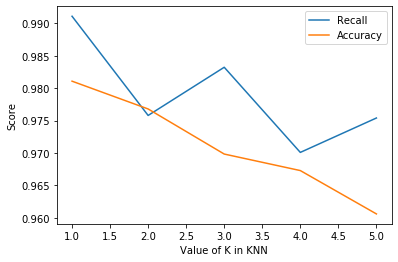

In [183]:
## Attempting KNN with Smote
X_train,X_test,y_train,y_test =train_test_split(X_smote, y_smote, stratify=y_smote, random_state=100)

k_range = [1, 2, 3, 4, 5]
accuracy = []
recall=[]
for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    recall.append(recall_score(y_test,y_pred))
    accuracy.append(accuracy_score(y_test,y_pred))
    
%matplotlib inline
plt.plot(k_range,recall,label= 'Recall')
plt.plot(k_range,accuracy,label= 'Accuracy')
plt.xlabel('Value of K in KNN')
plt.ylabel('Score')
plt.legend()

In [184]:
knn=KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print('Accuracy of KNN n=2 on the testing dataset is :{:.3f}'.format(accuracy_score(y_test,y_pred)))
print('Recall of KNN n=2 on the testing dataset is :{:.3f}'.format(recall_score(y_test,y_pred)))

Accuracy of KNN n=2 on the testing dataset is :0.977
Recall of KNN n=2 on the testing dataset is :0.976


### With smote dataset and KNN we get an accuracy of 97.7% and recall of 97.6%

In [185]:
# Decision Tree using SMOTE data
X = X_smote.copy()
y = y_smote.copy()

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt1 = DecisionTreeClassifier(max_depth=5)
dt1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [186]:
# The evaluation metrics of our default model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Making predictions
y_pred1 = dt1.predict(X_test)

# Printing classification report
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     84991
           1       0.98      0.96      0.97     85598

    accuracy                           0.97    170589
   macro avg       0.97      0.97      0.97    170589
weighted avg       0.97      0.97      0.97    170589



In [187]:
# Printing confusion matrix and accuracy
print(confusion_matrix(y_test,y_pred1))
print('Accuracy of Decision Tree :',accuracy_score(y_test,y_pred1))
print('Recall of Decision Tree   :',recall_score(y_test,y_pred1))

[[83437  1554]
 [ 3593 82005]]
Accuracy of Decision Tree : 0.9698280662879787
Recall of Decision Tree   : 0.9580247202037431


### With Decision Trees we get an accurancy of 96.9% and a recall of 95.8% without tuning the hyper parameters.

In [188]:
# Lets attempt a random forest with default parameters

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X = X_smote.copy()
y = y_smote.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)
print(classification_report(y_test,prediction_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84991
           1       1.00      1.00      1.00     85598

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589



In [189]:
# Printing confusion matrix
print(confusion_matrix(y_test, prediction_test))

[[84963    28]
 [    9 85589]]


In [190]:
print ('Random Forest Accuracy with Default Hyperparameter', accuracy_score(y_test, prediction_test))
print ('Random Forest Recall with Default Hyperparameter  ', recall_score(y_test, prediction_test))

Random Forest Accuracy with Default Hyperparameter 0.9997831044205664
Random Forest Recall with Default Hyperparameter   0.9998948573564803


### Random forest with default paramters gives us an accuracy and Recall of 99.99% !

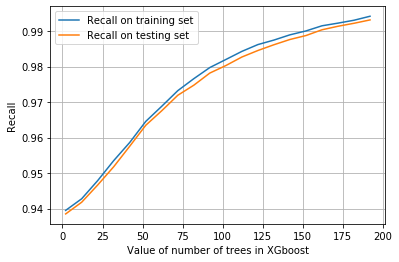

In [191]:
# Attempting XGBoost with Smote dataset
from xgboost import XGBClassifier

X = X_smote.copy()
y = y_smote.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

tree_range = range(2, 200, 10)
train_recall=[]
test_recall=[]
for tree in tree_range:
    xgb=XGBClassifier(n_estimators=tree)
    xgb.fit(X_train,y_train)
    y_train_pred = xgb.predict(X_train)
    y_test_pred = xgb.predict(X_test)
    train_recall.append(recall_score(y_train,y_train_pred))
    test_recall.append(recall_score(y_test,y_test_pred))
    
%matplotlib inline
plt.plot(tree_range,train_recall,label= 'Recall on training set')
plt.plot(tree_range,test_recall,label= 'Recall on testing set')
plt.xlabel('Value of number of trees in XGboost')
plt.ylabel('Recall')
plt.grid()
plt.legend()

## Hyperparameter tuning for XGBoost model

In [192]:
xgb=XGBClassifier(n_estimators=100)
xgb.fit(X_train,y_train)
y_test_pred = xgb.predict(X_test)
print('Accuracy of XGB n=100 on the testing dataset is :{:.3f}'.format(accuracy_score(y_test,y_test_pred)))
print('Recall of XGB n=100 on the testing dataset is :{:.3f}'.format(recall_score(y_test,y_test_pred)))

Accuracy of XGB n=100 on the testing dataset is :0.987
Recall of XGB n=100 on the testing dataset is :0.980


### We notice that the accuracy and recall both increase with increase in number of estimators. If we go with 100 estimators, we get an accuracy of 98.7% and a recall or 98.0%

## Since this is very performance intensive, lets not go for furthre improving the XGBoost model

### Print the class distribution after applying ADASYN

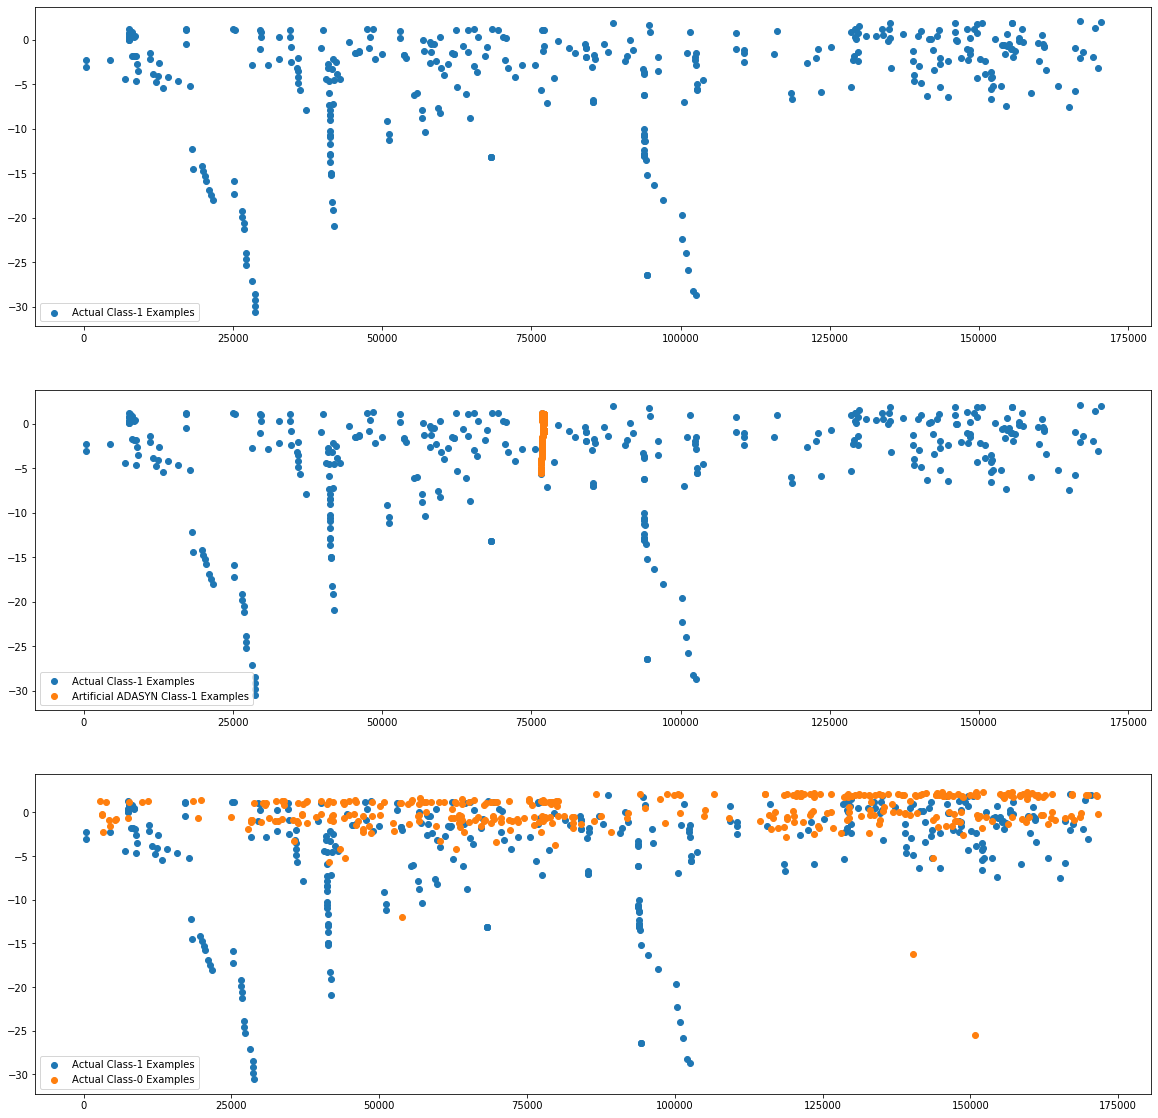

In [193]:
import warnings
warnings.filterwarnings("ignore")

from imblearn import over_sampling

X_train,X_test,y_train,y_test = train_test_split(X_orig, y_orig, stratify=y_orig, random_state=100)

ada = over_sampling.ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from ADASYN are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from ADASYN, we do
X_train_adasyn_1 = X_train_adasyn[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_adasyn_1[:X_train_1.shape[0], 0], X_train_adasyn_1[:X_train_1.shape[0], 1],
            label='Artificial ADASYN Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

In [194]:
#perform cross validation & then balance classes on X_train_cv & y_train_cv using SMOTE
# Stratified cross validation
X_adasyn, y_adasyn = ada.fit_resample(X_orig, y_orig)
X_adasyn = pd.DataFrame(X_adasyn)
y_adasyn = pd.DataFrame(y_adasyn)

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in skf.split(X_adasyn, y_adasyn):
    print("Train:", train_index, "Test:", test_index)
    X_train_cv, X_test_cv = X_adasyn.iloc[train_index], X_adasyn.iloc[test_index]
    y_train_cv, y_test_cv = y_adasyn.iloc[train_index], y_smote.iloc[test_index]

Train: [ 57020  57021  57022 ... 568610 568611 568612] Test: [     0      1      2 ... 341172 341173 341174]
Train: [     0      1      2 ... 568610 568611 568612] Test: [ 57020  57021  57022 ... 398032 398033 398034]
Train: [     0      1      2 ... 568610 568611 568612] Test: [113967 113968 113969 ... 454892 454893 454894]
Train: [     0      1      2 ... 568610 568611 568612] Test: [170949 170950 170951 ... 511751 511752 511753]
Train: [     0      1      2 ... 511751 511752 511753] Test: [227869 227870 227871 ... 568610 568611 568612]


In [195]:
X_adasyn.columns = X_orig.columns
y_adasyn.columns = ['Class']
print('1: ', len(y_adasyn[y_adasyn['Class'] == 1]))
print('0: ', len(y_adasyn[y_adasyn['Class'] == 0]))

1:  284298
0:  284315


### Number of fraudulent and non fraudulent transactions are now the same with ADASYN data injection

In [196]:
# attempting logistic Regression on ADASYN balanced data
# Logistic Regression on cross validated dataset
lr = LogisticRegression()
lr.fit(X_train_cv, y_train_cv)

# Predicted probabilities
y_pred = lr.predict(X_test_cv)

# Converting y_pred to a dataframe which is an array
df_y_pred = pd.DataFrame(y_pred)
# evaluation metrics
confusion = confusion_matrix(y_test_cv,y_pred)
print(confusion)

print("Logistic Regression accuracy after cross validation:  ",accuracy_score(y_test_cv,y_pred))
print("Logistic Regression recall after cross validation  :  ",recall_score(y_test_cv,y_pred))


[[56762   101]
 [ 4386 52473]]
Logistic Regression accuracy after cross validation:   0.9605441339406623
Logistic Regression recall after cross validation  :   0.9228618160713343


## We have an accuracy of 96.1% and high recall of 92.3% with logistic regression

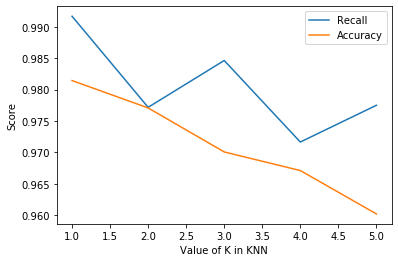

In [197]:
## Attempting KNN with Adasyn
X_train,X_test,y_train,y_test =train_test_split(X_adasyn, y_adasyn, stratify=y_adasyn, random_state=100)

k_range = [1, 2, 3, 4, 5]
accuracy = []
recall=[]
for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    recall.append(recall_score(y_test,y_pred))
    accuracy.append(accuracy_score(y_test,y_pred))
    
%matplotlib inline
plt.plot(k_range,recall,label= 'Recall')
plt.plot(k_range,accuracy,label= 'Accuracy')
plt.xlabel('Value of K in KNN')
plt.ylabel('Score')
plt.legend()

In [198]:
knn=KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print('Accuracy of KNN n=2 on the testing dataset is :{:.3f}'.format(accuracy_score(y_test,y_pred)))
print('Recall of KNN n=2 on the testing dataset is :{:.3f}'.format(recall_score(y_test,y_pred)))

Accuracy of KNN n=2 on the testing dataset is :0.977
Recall of KNN n=2 on the testing dataset is :0.977


### With adasyn dataset and KNN we get an accuracy and recall of 97.7% !!

In [199]:
# Decision Tree using ADASYN data
X = X_adasyn.copy()
y = y_adasyn.copy()

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt1 = DecisionTreeClassifier(max_depth=5)
dt1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [200]:
# The evaluation metrics of our default model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Making predictions
y_pred1 = dt1.predict(X_test)

# Printing classification report
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     85045
           1       0.98      0.95      0.97     85539

    accuracy                           0.97    170584
   macro avg       0.97      0.97      0.97    170584
weighted avg       0.97      0.97      0.97    170584



In [201]:
# Printing confusion matrix and accuracy
print(confusion_matrix(y_test,y_pred1))
print('Accuracy of Decision Tree :',accuracy_score(y_test,y_pred1))
print('Recall of Decision Tree   :',recall_score(y_test,y_pred1))

[[83567  1478]
 [ 4064 81475]]
Accuracy of Decision Tree : 0.9675116071847301
Recall of Decision Tree   : 0.9524895077099335


### With Decision Trees we get an accurancy of 96.8% and a recall of 95.2% without tuning the hyper parameters.

In [202]:
# Lets attempt a random forest with default parameters

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X = X_adasyn.copy()
y = y_adasyn.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)
print(classification_report(y_test,prediction_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85045
           1       1.00      1.00      1.00     85539

    accuracy                           1.00    170584
   macro avg       1.00      1.00      1.00    170584
weighted avg       1.00      1.00      1.00    170584



In [203]:
# Printing confusion matrix
print(confusion_matrix(y_test, prediction_test))

[[85020    25]
 [    4 85535]]


In [204]:
print ('Random Forest Accuracy with Default Hyperparameter', accuracy_score(y_test, prediction_test))
print ('Random Forest Recall with Default Hyperparameter  ', recall_score(y_test, prediction_test))

Random Forest Accuracy with Default Hyperparameter 0.9998299957792055
Random Forest Recall with Default Hyperparameter   0.9999532377044389


### Random forest with default parameters gives us an accuracy and Recall of 99.99% !

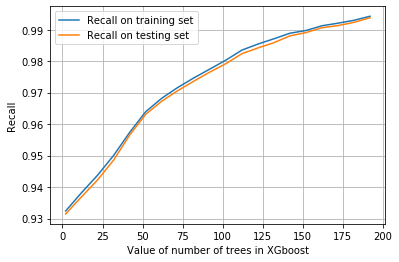

In [205]:
# Attempting XGBoost with Smote dataset
from xgboost import XGBClassifier

X = X_adasyn.copy()
y = y_adasyn.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

tree_range = range(2, 200, 10)
train_recall=[]
test_recall=[]
for tree in tree_range:
    xgb=XGBClassifier(n_estimators=tree)
    xgb.fit(X_train,y_train)
    y_train_pred = xgb.predict(X_train)
    y_test_pred = xgb.predict(X_test)
    train_recall.append(recall_score(y_train,y_train_pred))
    test_recall.append(recall_score(y_test,y_test_pred))
    
%matplotlib inline
plt.plot(tree_range,train_recall,label= 'Recall on training set')
plt.plot(tree_range,test_recall,label= 'Recall on testing set')
plt.xlabel('Value of number of trees in XGboost')
plt.ylabel('Recall')
plt.grid()
plt.legend()

## Hyperparameter tuning for XGBoost model

In [206]:
xgb=XGBClassifier(n_estimators=130)
xgb.fit(X_train,y_train)
y_test_pred = xgb.predict(X_test)
print('Accuracy of XGB n=130 on the testing dataset is :{:.3f}'.format(accuracy_score(y_test,y_test_pred)))
print('Recall of XGB n=130 on the testing dataset is :{:.3f}'.format(recall_score(y_test,y_test_pred)))

Accuracy of XGB n=130 on the testing dataset is :0.990
Recall of XGB n=130 on the testing dataset is :0.985


### We notice that the accuracy and recall both increase with increase in number of estimators. If we go with 130 estimators, we get an accuracy of 99.0% and a recall or 98.5%

## Since this is very performance intensive, lets not go for furthre improving the XGBoost model

### Select the oversampling method which shows the best result on a model
- Apply the best hyperparameter on the model
- Predict on the test dataset

In [207]:
# perform the best oversampling method on X_train & y_train

X = X_adasyn.copy()
y = y_adasyn.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

clf = RandomForestClassifier()  #initialise the model with optimum hyperparameters
clf.fit(X_train, y_train) # fit on the balanced dataset
# Make predictions
prediction_test = clf.predict(X_test)
print('Recall score of best model:', recall_score(y_test, prediction_test)) #print the evaluation score on the X_test by choosing the best evaluation metric

Recall score of best model: 0.9999766188522194


### Print the important features of the best model to understand the dataset

Top var = 13
2nd Top var = 15
3rd Top var = 5


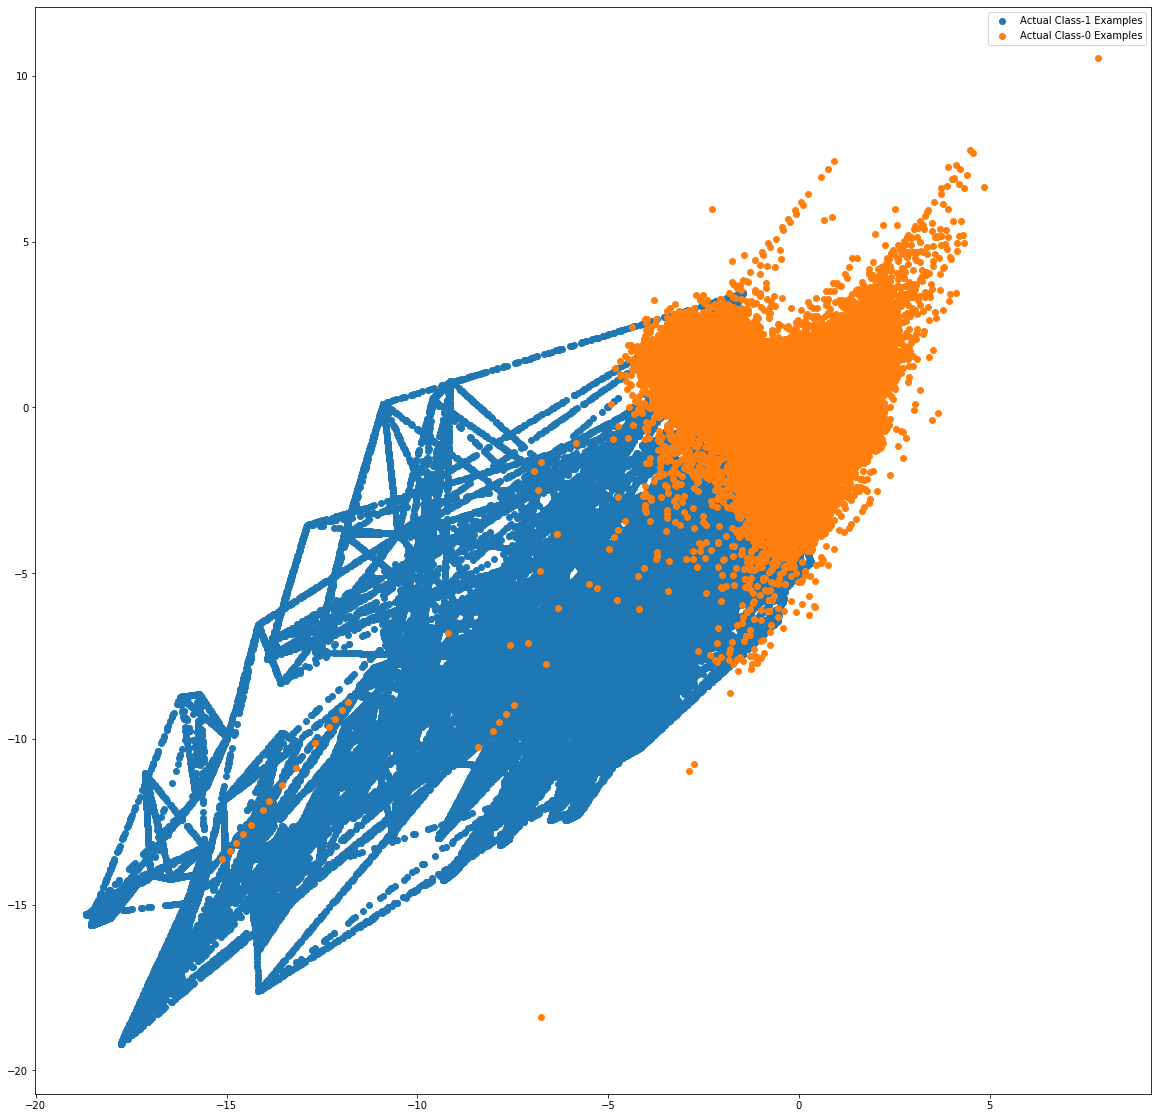

In [208]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-15 and Index-5 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train['Class'] = y_train
X_train_1 = X_train[X_train['Class'] == 1].drop('Class', axis=1)
X_train_0 = X_train[X_train['Class'] == 0].drop('Class', axis=1)

np.random.shuffle(X_train_0.to_numpy())

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1.iloc[:, top_var_index], X_train_1.iloc[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0.iloc[:X_train_1.shape[0], top_var_index], X_train_0.iloc[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

In [209]:
#### Print the FPR,TPR & select the best threshold from the roc curve

In [215]:
print('AUC Score: ', metrics.roc_auc_score(y_test, prediction_test))
fpr, tpr, thresholds = metrics.roc_curve(y_test, prediction_test)
print('FPR: ', fpr.round(2))
print('TPR: ', tpr.round(2))
threshold = thresholds[np.argmax(tpr-fpr)]
print('Threshold: ', threshold)

AUC Score:  0.9998707246180669
FPR:  [0. 0. 1.]
TPR:  [0. 1. 1.]
Threshold:  1


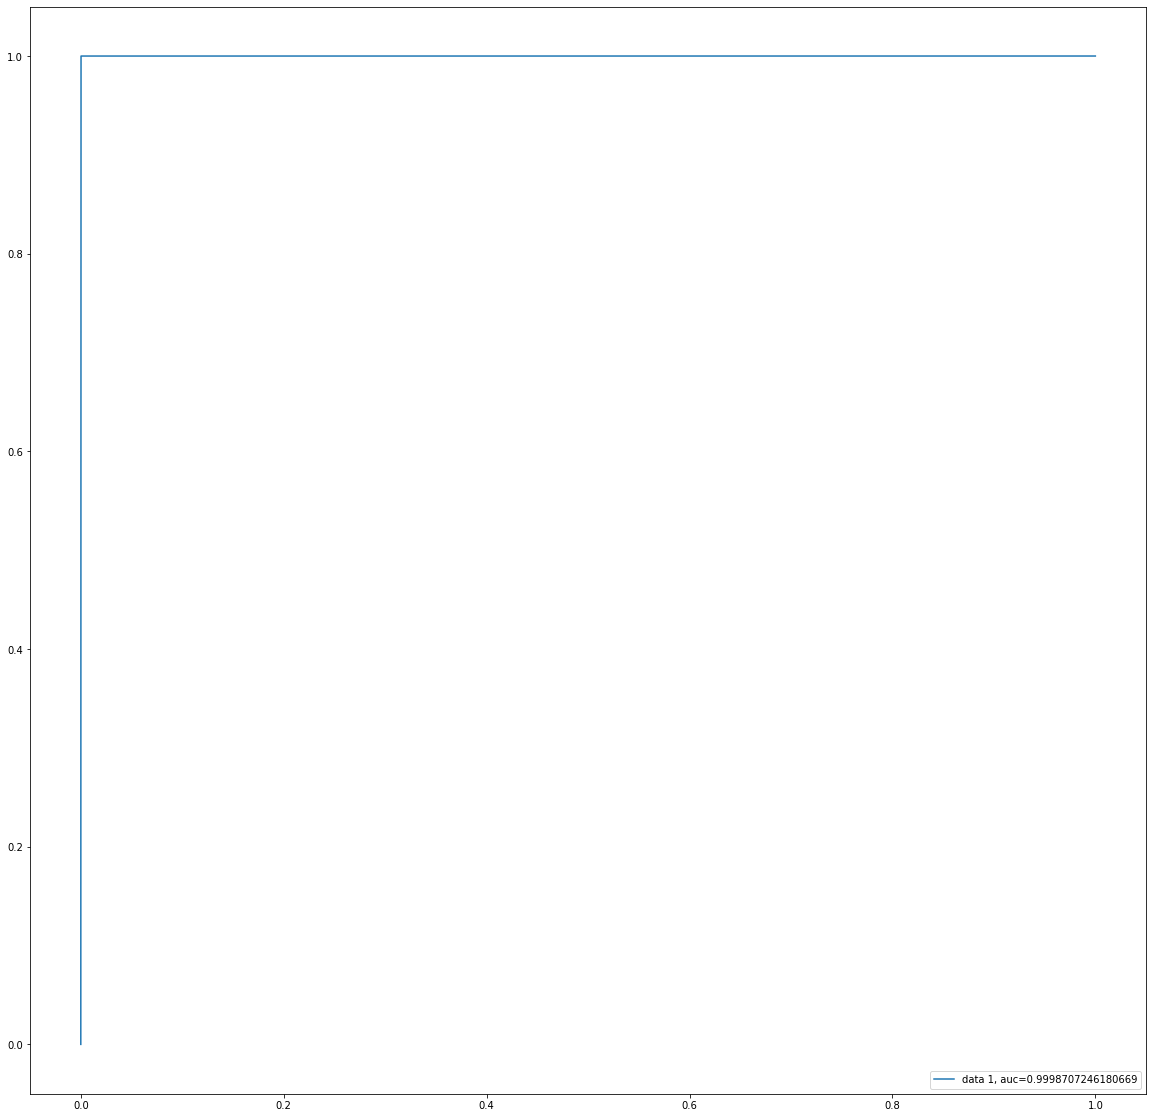

In [211]:
plt.plot(fpr,tpr,label="data 1, auc="+str(metrics.roc_auc_score(y_test, prediction_test)))
plt.legend(loc=4)
plt.show()

## As can be seen from the ROC curve, we have a very good model with a very high auc score ~ 1

# Cost-Benefit Analysis

In [212]:
# Printing confusion matrix
conf_matrix = confusion_matrix(y_test, prediction_test)
print(conf_matrix)

[[85025    20]
 [    2 85537]]


In [213]:
print('Total fraud predictions (TP + FP): ', conf_matrix[1].sum())
print('Call Cost @ Rs. 10 per call:  ', conf_matrix[1].sum() * 10)

Total fraud predictions (TP + FP):  85539
Call Cost @ Rs. 10 per call:   855390


In [225]:
X_cost_analysis = X_test.copy()
X_cost_analysis['Actual'] = y_test
X_cost_analysis['Prediction'] = prediction_test
saved_transactions = X_cost_analysis[(X_cost_analysis['Actual'] == 1) & (X_cost_analysis['Prediction'] == 1)]
saved_txn_amt = saved_transactions['Amount'].sum()
saved_txn_cnt = saved_transactions['Amount'].count()
print('saved amt: ', saved_txn_amt, ' saved cnt: ', saved_txn_cnt)

lost_transactions = X_cost_analysis[(X_cost_analysis['Actual'] == 1) & (X_cost_analysis['Prediction'] == 0)]
lost_txn_amt = lost_transactions['Amount'].sum()
lost_txn_cnt = lost_transactions['Amount'].count()
print('lost amt: ',  lost_txn_amt, ' lost cnt: ', lost_txn_cnt)

print('Total_savings: ', round(saved_txn_amt - (conf_matrix[1].sum() * 10) - lost_txn_amt, 2))


saved amt:  9283554.18812851  saved cnt:  85537
lost amt:  39.17910527873468  lost cnt:  2
Total_savings:  8428125.01


## Cost benefit to the bank based on the current test data set is : 
# Rs. 84,28,125.01